# Notebook to calculate euclidean distance between two localisation lists (for example from RS-FISH)

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import copy
from scipy import spatial

In [30]:
def compare_point_lists(listA, listB, matching_threshold=2):
    """
    Compare two sets of points (listA vs. listB).
    
    Parameters
    ----------
    listA : np.ndarray
        Nx2 (or Nx3) array of (x,y) or (x,y,z) coordinates in List A.
    listB : np.ndarray
        Mx2 (or Mx3) array of (x,y) or (x,y,z) coordinates in List B.
    matching_threshold : float, optional
        Distance threshold under which we consider points to be a match.
    
    Returns
    -------
    unmatchedA : int
        Number of unmatched points remaining in listA.
    unmatchedB : int
        Number of unmatched points remaining in listB.
    mean_dist : float
        Mean Euclidean distance among matched point pairs.
    matchedA : np.ndarray
        Coordinates of points in listA that have found a match in listB.
    matchedB : np.ndarray
        Coordinates of points in listB that have found a match in listA.
    distance_arr : np.ndarray
        Array of distances for each matched pair.
    """
    # Initialize
    distance_arr = []
    removedItems = True

    # Make copies that we can pop from
    listA = np.array(listA, copy=True)
    listB = np.array(listB, copy=True)

    # These lists will store the matched points
    matchedA = []
    matchedB = []

    # We keep matching until we can’t find any pairs below matching_threshold
    while removedItems and len(listA) > 0 and len(listB) > 0:
        # minDist will track the smallest distance found in the current pass
        minDist = 1e10  # (A large number to be replaced by any smaller real distance)
        minIndexA = -1
        minIndexB = -1

        # Build a KDTree from listB
        listB_copy = copy.deepcopy(listB)
        kdtree = spatial.KDTree(listB_copy)

        # For each point in listA, find its closest match in listB
        for i, pointA in enumerate(listA):
            distance, indexB = kdtree.query(pointA)
            if distance < minDist:
                minDist = distance
                minIndexA = i
                minIndexB = indexB

        # Check if the smallest match is below the matching threshold
        if minDist < matching_threshold:
            # They are considered a valid match
            matchedA.append(listA[minIndexA])
            matchedB.append(listB[minIndexB])

            # Remove matched points from both arrays
            listA = np.delete(listA, minIndexA, axis=0)
            listB = np.delete(listB, minIndexB, axis=0)
            distance_arr.append(minDist)
            removedItems = True
        else:
            removedItems = False

    distance_arr = np.asarray(distance_arr)
    mean_dist = np.mean(distance_arr) if len(distance_arr) > 0 else 0

    # Return how many are unmatched in A or B, plus details on matched ones
    return (len(listA),         # unmatchedA
            len(listB),         # unmatchedB
            mean_dist,          
            np.asarray(matchedA),
            np.asarray(matchedB),
            distance_arr)


def find_match_indices(listA, listB, matchedA, matchedB):
    """
    Returns the indices (row positions) in the original arrays (listA/listB)
    corresponding to the matched points in matchedA/matchedB.
    
    Parameters
    ----------
    listA : np.ndarray
        Original Nx2 or Nx3 array of points (List A).
    listB : np.ndarray
        Original Mx2 or Mx3 array of points (List B).
    matchedA : np.ndarray
        Subset of points from listA that were matched.
    matchedB : np.ndarray
        Subset of points from listB that were matched.
        
    Returns
    -------
    idxsA : np.ndarray
        Indices of matched points from listA in the original array.
    idxsB : np.ndarray
        Indices of matched points from listB in the original array.
    """
    idxsA = []
    idxsB = []
    
    for i in range(len(matchedA)):
        # Where does matchedA[i] appear in listA?
        idxA = np.where((listA == matchedA[i]).all(axis=1))[0]
        # Where does matchedB[i] appear in listB?
        idxB = np.where((listB == matchedB[i]).all(axis=1))[0]
        
        idxsA.append(idxA)
        idxsB.append(idxB)
    
    # Flatten
    idxsA = np.concatenate(idxsA) if len(idxsA) > 0 else []
    idxsB = np.concatenate(idxsB) if len(idxsB) > 0 else []
    
    return idxsA, idxsB


In [31]:
# Provide your CSV paths (with columns x,y, [optionally z,t,c,intensity,...])

listA_csv_path  = "/Users/laurabreimann/Downloads/smFISH_localizations1.csv"
listB_csv_path = "/Users/laurabreimann/Downloads/smFISH_localizations2.csv"

In [32]:
dfA = pd.read_csv(listA_csv_path)
dfB = pd.read_csv(listB_csv_path)

# If your CSV only has x,y columns
listA_points = dfA[["x","y"]].values
listB_points = dfB[["x","y"]].values

# Compare the two lists (adjust matching_threshold if necessary)
unmatchedA, unmatchedB, mean_dist, matchedA, matchedB, dist_array = compare_point_lists(
    listA_points,
    listB_points,
    matching_threshold=3  # <--- Distance threshold, can we set by user to adjust sensitivity
)


In [33]:
# Print some summary stats
print(f"Unmatched in List A = {unmatchedA}")
print(f"Unmatched in List B = {unmatchedB}")
print(f"Number of matched pairs = {len(matchedA)}")
print(f"Mean distance of matched pairs = {mean_dist:.4f}")

# If needed, find the original indices of matched points
idxsA, idxsB = find_match_indices(listA_points, listB_points, matchedA, matchedB)
print(f"Matched indices from List A: {idxsA}")
print(f"Matched indices from List B: {idxsB}")

# Build a DataFrame for matched pairs
matched_df = pd.DataFrame({
    "A_index": idxsA,
    "B_index": idxsB,
    "A_point": [list(pt) for pt in matchedA],
    "B_point": [list(pt) for pt in matchedB],
    "distance": dist_array
})

matched_df.head()



Unmatched in List A = 534
Unmatched in List B = 248
Number of matched pairs = 336
Mean distance of matched pairs = 1.8899
Matched indices from List A: [815 721 121  75 218 446 549 118 150 707  62 402 139 583 430 620  21 409
 246 401 405 127 627 207 437 288 749 524 531 436  29  77 386 263 251 280
 281 801  42  53 825 101  16 403 190 420  58 369  78 254 385 603 266 756
 853 294  27 136 232 122 177 758   8 698 231 517 322 154 300 414 108 623
 770  57 279 247 855  83 671 365 149 180  90 428 506 503 425 859 400 440
  93 502  35 152 442 814 544 148 478 151 230 828  48 861 625 115 219 434
 600 187   7 728 312 116 285 680 578 204 201  87 228  79 315  49 252 444
 272 153  11 332 796 184 164 450 837 162 833  25  22 349 217 555  74 582
 165  31 523 243 676 205 374 394 678 157 174 648 604 197 416 720 226 182
 548 533 388 790 172  50 357 212 803 845 241 377 712 597 188  89 135 823
 275 637  65 585 375 346 134  30 609  76 690 293 537 525 337  39 161 761
 653  37 238 577 554 295  86 328 194 370 143 1

,A_index,B_index,A_point,B_point,distance
0,815,506,"[301.0292, 338.0563]","[301.073, 337.9255]",0.137939
1,721,442,"[159.9932, 299.3242]","[160.0767, 299.1741]",0.171762
2,121,84,"[216.6414, 89.1146]","[216.4755, 89.1592]",0.171790
3,75,55,"[161.7633, 70.5097]","[161.4761, 70.5968]",0.300117
4,218,161,"[112.281, 127.6013]","[111.9866, 127.6795]",0.304609


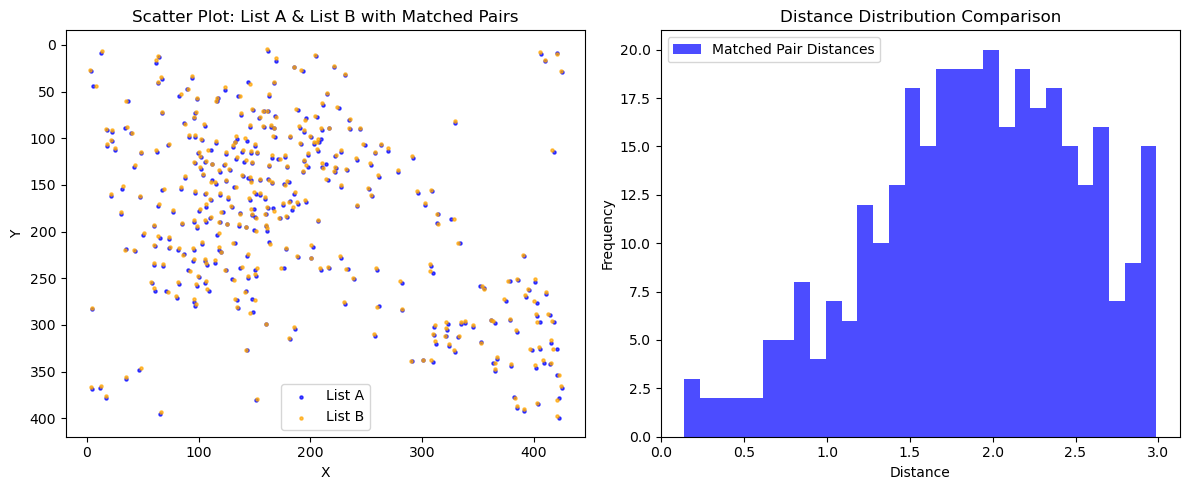

In [39]:
import matplotlib.pyplot as plt

# -------------------------------
# Plotting the results
# -------------------------------
plt.figure(figsize=(12, 5))

# --- Left Panel: Scatter Plot with Matched Pairs ---
plt.subplot(1, 2, 1)
plt.scatter(matchedA[:, 0], matchedA[:, 1], c='blue', label='List A', alpha=0.7, s=5)
plt.scatter(matchedB[:, 0], matchedB[:, 1], c='orange', label='List B', alpha=0.7, s=5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot: List A & List B with Matched Pairs")
plt.legend()

# Invert the y-axis to correct horizontal flip
plt.gca().invert_yaxis()

# --- Right Panel: Histograms of Distances ---
plt.subplot(1, 2, 2)
# Matched pair distances (blue)
plt.hist(dist_array, bins=30, color='blue', alpha=0.7, label='Matched Pair Distances')
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distance Distribution Comparison")
plt.legend()

plt.tight_layout()
plt.show()


## Make control plot showing self nearest neighbor distances of each list

Unmatched in List A: 690
Unmatched in List B: 404
Mean matched distance: 1.4167


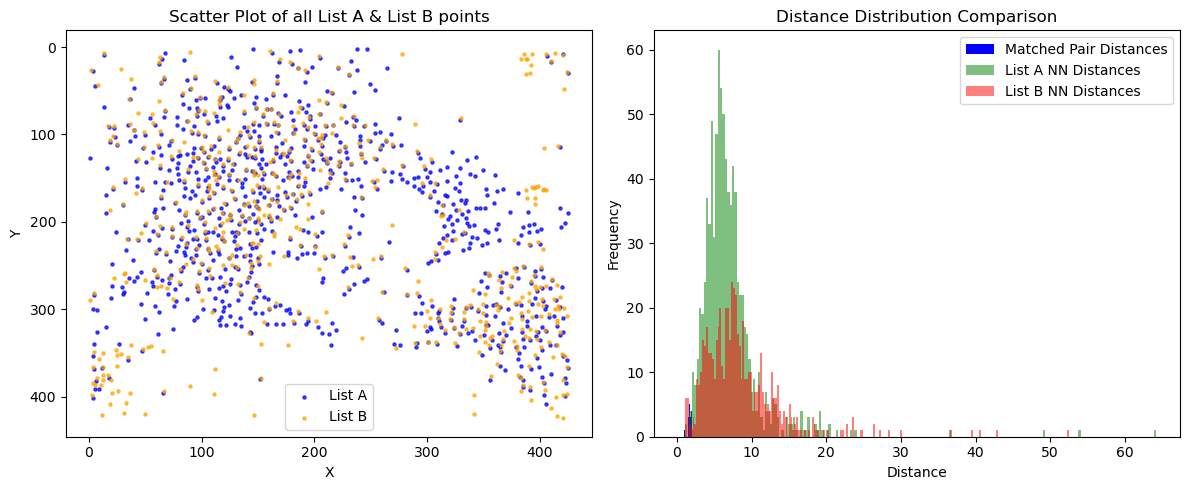

In [41]:
import numpy as np
import pandas as pd
import copy
from scipy import spatial
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# -------------------------------
# (Re)Define the comparison functions
# -------------------------------

def compare_point_lists(listA, listB, matching_threshold=2):
    """
    Compare two sets of points (listA vs. listB).

    Parameters
    ----------
    listA : np.ndarray
        Nx2 (or Nx3) array of coordinates.
    listB : np.ndarray
        Mx2 (or Mx3) array of coordinates.
    matching_threshold : float, optional
        Distance threshold for two points to be considered a match.

    Returns
    -------
    unmatchedA : int
        Number of points remaining in listA after matching.
    unmatchedB : int
        Number of points remaining in listB after matching.
    mean_dist : float
        Mean Euclidean distance among matched pairs.
    matchedA : np.ndarray
        Matched points from listA.
    matchedB : np.ndarray
        Matched points from listB.
    distance_arr : np.ndarray
        Array of distances for each matched pair.
    """
    distance_arr = []
    removedItems = True

    # Copy so we can remove matched points
    listA = np.array(listA, copy=True)
    listB = np.array(listB, copy=True)

    matchedA = []
    matchedB = []

    while removedItems and len(listA) > 0 and len(listB) > 0:
        minDist = 1e10  # Start with a very large number
        minIndexA = -1
        minIndexB = -1

        # Build KDTree from listB
        listB_copy = copy.deepcopy(listB)
        kdtree = spatial.KDTree(listB_copy)

        # For every point in listA, find its closest neighbor in listB
        for i, pointA in enumerate(listA):
            distance, indexB = kdtree.query(pointA)
            if distance < minDist:
                minDist = distance
                minIndexA = i
                minIndexB = indexB

        # If the best (smallest) distance is within our threshold, accept it as a match
        if minDist < matching_threshold:
            matchedA.append(listA[minIndexA])
            matchedB.append(listB[minIndexB])
            listA = np.delete(listA, minIndexA, axis=0)
            listB = np.delete(listB, minIndexB, axis=0)
            distance_arr.append(minDist)
            removedItems = True
        else:
            removedItems = False

    distance_arr = np.asarray(distance_arr)
    mean_dist = np.mean(distance_arr) if len(distance_arr) > 0 else 0

    return (len(listA),         # unmatched points from List A
            len(listB),         # unmatched points from List B
            mean_dist,
            np.asarray(matchedA),
            np.asarray(matchedB),
            distance_arr)

# -------------------------------
# Example: Load your CSV files for List A and List B
# -------------------------------
# Update these paths to your actual CSV files
listA_csv_path = "/Users/laurabreimann/Downloads/smFISH_localizations1.csv"
listB_csv_path = "/Users/laurabreimann/Downloads/smFISH_localizations2.csv"

# Assume CSV files have headers: x, y, t, c, intensity
dfA = pd.read_csv(listA_csv_path)
dfB = pd.read_csv(listB_csv_path)

# Extract the coordinates (adjust if you have 3D data)
listA_points = dfA[["x","y"]].values
listB_points = dfB[["x","y"]].values

# -------------------------------
# Compare the two lists to get matched pairs and their distances
# -------------------------------
unmatchedA, unmatchedB, mean_dist, matchedA, matchedB, dist_array = compare_point_lists(
    listA_points, listB_points, matching_threshold=2)

print(f"Unmatched in List A: {unmatchedA}")
print(f"Unmatched in List B: {unmatchedB}")
print(f"Mean matched distance: {mean_dist:.4f}")

# -------------------------------
# Compute control distances: nearest-neighbor distances within each list
# -------------------------------
# For List A: Exclude the point itself (k=2, take the second closest)
treeA = KDTree(listA_points)
distances_A, _ = treeA.query(listA_points, k=2)
nn_dists_A = distances_A[:, 1]  # nearest neighbor distances for List A

# For List B:
treeB = KDTree(listB_points)
distances_B, _ = treeB.query(listB_points, k=2)
nn_dists_B = distances_B[:, 1]  # nearest neighbor distances for List B

# -------------------------------
# Plotting the results
# -------------------------------
plt.figure(figsize=(12, 5))

# --- Left Panel: Scatter Plot with Matched Pairs ---
plt.subplot(1, 2, 1)
plt.scatter(listA_points[:, 0], listA_points[:, 1], c='blue', label='List A', alpha=0.7, s=5)
plt.scatter(listB_points[:, 0], listB_points[:, 1], c='orange', label='List B', alpha=0.7, s=5)
# Draw lines connecting each matched pair
for pointA, pointB in zip(matchedA, matchedB):
    plt.plot([pointA[0], pointB[0]], [pointA[1], pointB[1]], c='gray', lw=1, alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot of all List A & List B points")
plt.legend()

# Invert the y-axis to correct horizontal flip
plt.gca().invert_yaxis()

# --- Right Panel: Histograms of Distances ---
plt.subplot(1, 2, 2)
# Matched pair distances (blue)
plt.hist(dist_array, bins=200, color='blue', alpha=1, label='Matched Pair Distances')
# Nearest neighbor distances within List A (green)
plt.hist(nn_dists_A, bins=200, color='green', alpha=0.5, label='List A NN Distances')
# Nearest neighbor distances within List B (red)
plt.hist(nn_dists_B, bins=200, color='red', alpha=0.5, label='List B NN Distances')
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distance Distribution Comparison")
plt.legend()

plt.tight_layout()
plt.show()